# Pipeline

In [1]:
"""markdown
    TITLE   : Pipeline Per Globular Cluster
    PROJECT : Astrostats Final Project
""";

<span style='font-size:30px;font-weight:650'>
    About
</span>

The pipeline per GC. This needs to be run on the combined GC set, which will require some minor alterations.


<br><br>

- - - 
- - - 


# Prepare

## Imports

In [2]:
from astroPHD import ipython
ipython.run_imports(base=True, astropy=True, matplotlib=True,
                    verbose_imports=False)
ipython.set_autoreload(2)

set autoreload to 1
set autoreload to 2


In [3]:
# GENERAL
import re
import os
import sys
import numpy as np
import scipy.stats as stats
import astropy.units as u
from astropy.coordinates import SkyCoord

from galpy.df import jeans
from galpy import potential

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# CUSTOM

# PROJECT-SPECIFIC
sys.path.insert(0, '../')
import src
from src import (
    convert_angle, convert_pm_angular,
    load_summary_table, load_globular_cluster,
    GlobularCluster
)
from src import plot
from src.utils import profile_binning
from src.GMM import GMM, GMM_bins
# from src.modeling import vel_disp_profile
from src.plot import colobar_non_mappable

  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_interppotential_c.cpython-37m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_integrate_c.cpython-37m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_integrate_c.cpython-37m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_integrate_c.cpython-37m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_actionAngle_c.cpython-37m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_actionAngle_c.cpython-37m-darwin.so
  Reason: image not found' 


In [4]:
rng = np.random.RandomState(0)

## Load Data

In [5]:
drct = "../scripts/get_globular_clusters/"
gc_name = "NGC_104_47Tuc"

In [6]:
GC = GlobularCluster.from_directory(gc_name, drct)

### Summary Results

In [7]:
GC.summary

Name,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp,pm,sc
,deg,deg,kpc,km / s,km / s,km / s,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,,,arcmin,mas / yr,mas / yr,"kpc,kpc,kpc"
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
NGC_104_47Tuc,6.02363,-72.081,4.5,-17.2,0.2,12.2,40.0,5.237,-2.524,0.039,0.039,-0.002,23917.2,18.3,0.418,5.8134967962492246,"1.3768803520135555,0.14529010919422544,-4.281715927103217"


### Globular Cluster Data

In [8]:
GC.df[:1]

x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm
deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,,,deg,mas / yr
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0.1172196,-0.2248786,5.719238,-2.529692,0.8540644,0.5317305,-0.5317841,19.20259,nan,0,0.0,0.2535957794643279,6.253720885641443


In [9]:
GC.df.to_pandas().describe()

,x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm
count,89986.000000,89986.000000,89986.000000,89986.000000,89986.000000,89986.000000,89986.000000,89986.000000,72469.000000,89986.000000,89986.000000,89986.000000,89986.000000
mean,0.000116,-0.001035,5.032141,-2.386119,0.743283,0.616515,-0.075613,18.661010,0.901703,0.187118,0.173289,0.155954,5.899688
std,0.120347,0.120393,2.083841,1.595911,0.691594,0.598613,0.199957,1.435372,0.196405,0.390008,0.375244,0.068244,1.760392
min,-0.304802,-0.304871,-14.204800,-14.917570,0.023578,0.020528,-0.951285,10.600150,-1.243570,0.000000,0.000000,0.001046,0.014232
25%,-0.087051,-0.089093,4.561004,-2.977472,0.281450,0.231498,-0.184031,17.859742,0.791414,0.000000,0.000000,0.102369,5.266180
50%,-0.000884,-0.000482,5.221530,-2.454192,0.523285,0.422876,-0.070846,18.807490,0.873260,0.000000,0.000000,0.147681,5.869699
75%,0.087445,0.086653,5.820543,-1.873645,0.963112,0.765575,0.027666,19.687098,0.997660,0.000000,0.000000,0.206281,6.482189
max,0.304218,0.304813,14.879210,14.198930,5.227345,5.189505,0.982183,20.999230,4.339368,1.000000,0.998725,0.304992,14.995575


<br><br>

- - - 
- - - 


# Pipeline

Summary Plot

In [75]:
# print(os.listdir(drct+'output'))

In [61]:
GC = GlobularCluster.from_directory('NGC_104_47Tuc', drct)

(-5, 20)

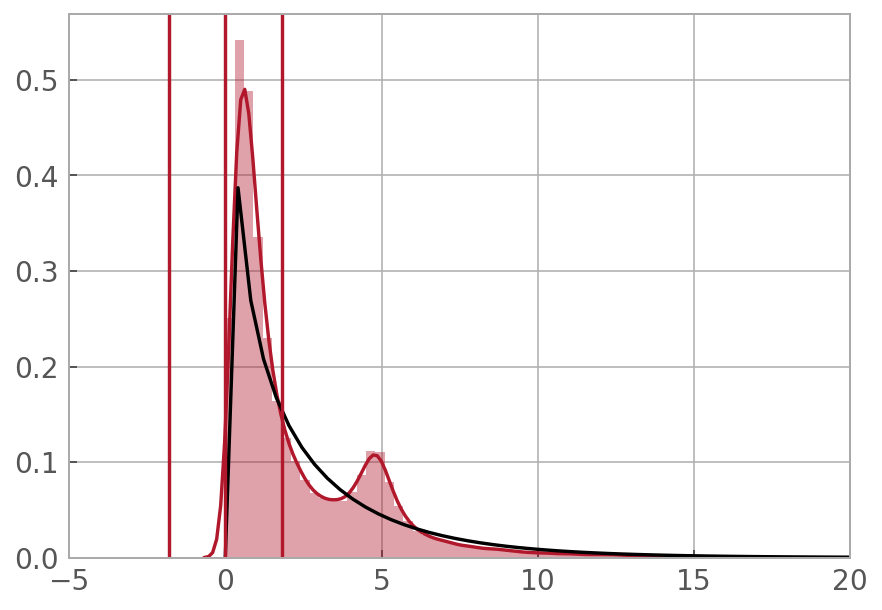

In [83]:
median = astropy.stats.biweight_location(GC.df_full['pmx'].value)
mux = GC.df_full['pmx'].value - median

# sns.distplot(mux[np.abs(mux) < 15], color='blue')

median = astropy.stats.biweight_location(GC.df_full['pmy'].value)
muy = GC.df_full['pmy'].value - median

# sns.distplot(muy[np.abs(muy) < 15], color='green')

pm = np.hypot(mux, muy)

dof, loc, scale = scipy.stats.chi2.fit(pm)


# std = astropy.stats.mad_std(pm)

sns.distplot(pm[pm < 15])
x = np.linspace(0, 20)
plt.plot(x, scipy.stats.chi2.pdf(x, dof, loc, scale), c='k')
plt.axvline(loc)
plt.axvline(loc - scale)
plt.axvline(loc + scale)
plt.xlim(-5, 20)

In [78]:
res

(1.2826563675739107, 0.00424590131003326, 1.8105282176898716)

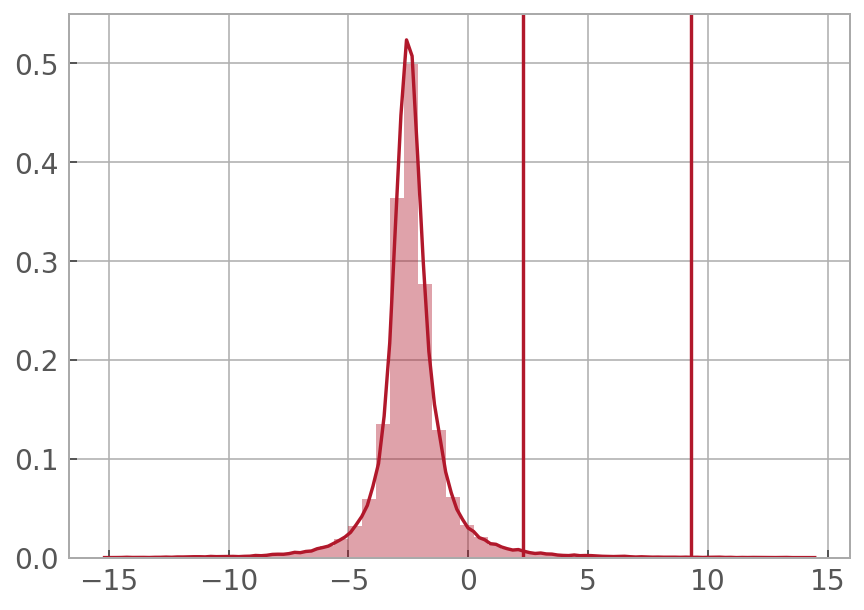

In [63]:
sns.distplot(GC.df['pmy'].value)

median = astropy.stats.biweight_location(GC.df_full['pm'].value)
std = astropy.stats.mad_std(GC.df_full['pm'].value)

plt.axvline(median - 3*std)
plt.axvline(median + 3*std)

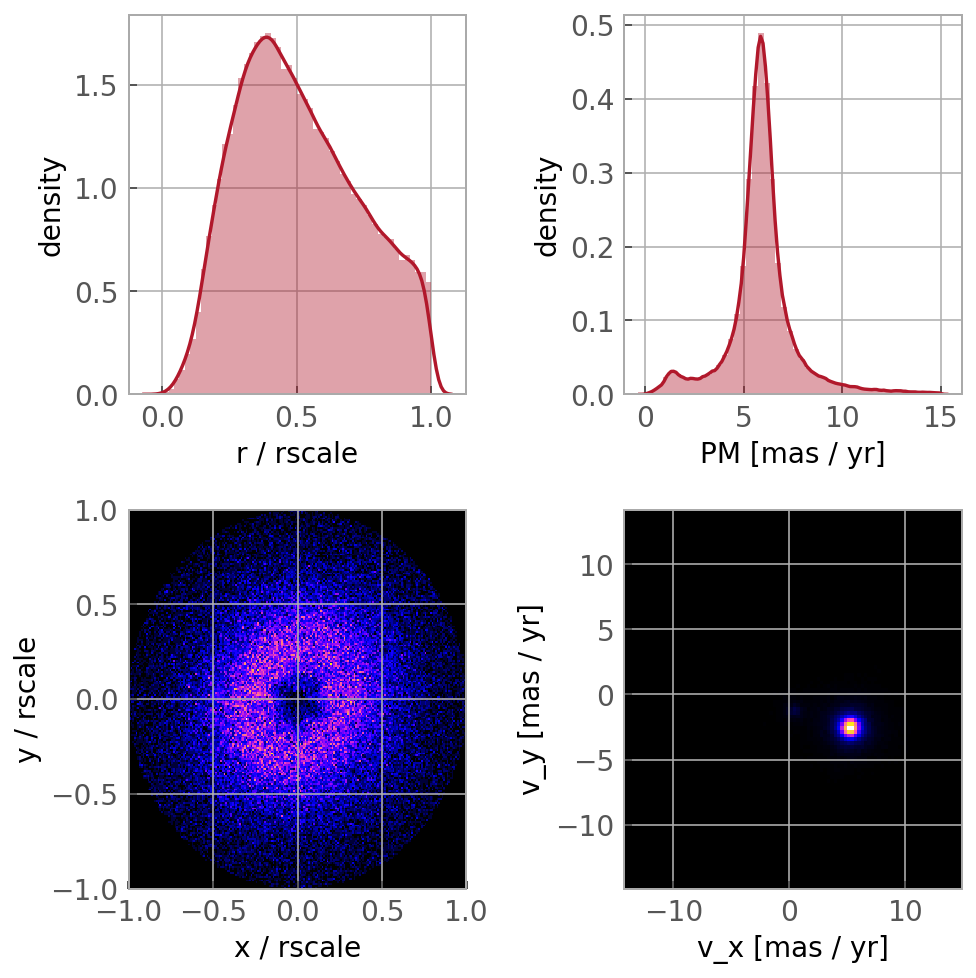

In [64]:
plot.plot_gc_hist2d_summary(GC);

Text(0.5,0,'r / r$_{scale}$')

Text(0,0.5,'PM')

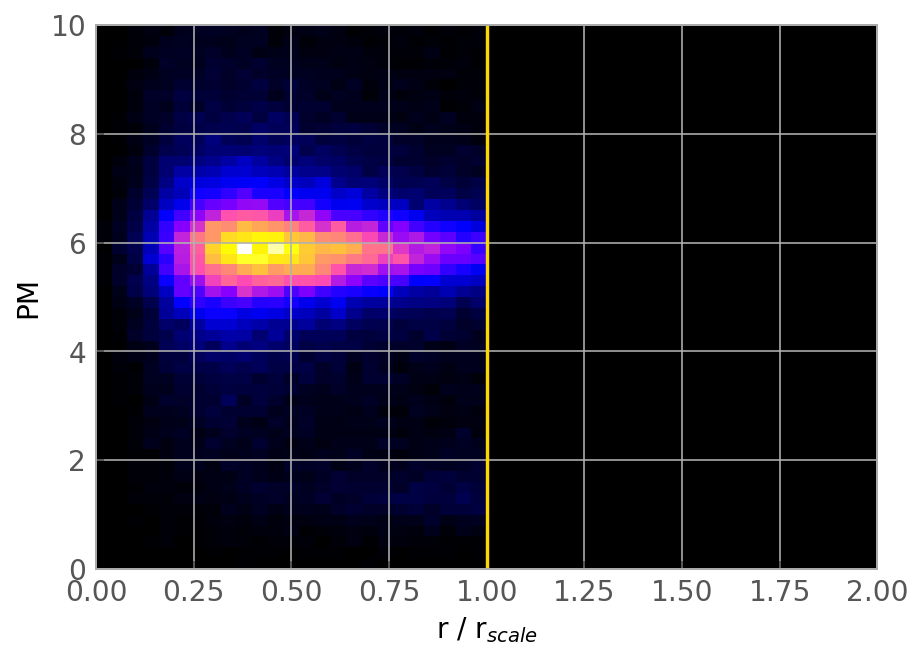

In [19]:
H, xb, yb, _ = plt.hist2d(
    GC.r, GC.pm.value,
    bins=50, range=[[0,2],[0,10]],
    cmap="gnuplot2"
)
# R scale
plt.axvline(1, color="gold")
plt.xlabel(r"r / r$_{scale}$")
plt.ylabel("PM")

### Binning

<Figure size 504x360 with 0 Axes>

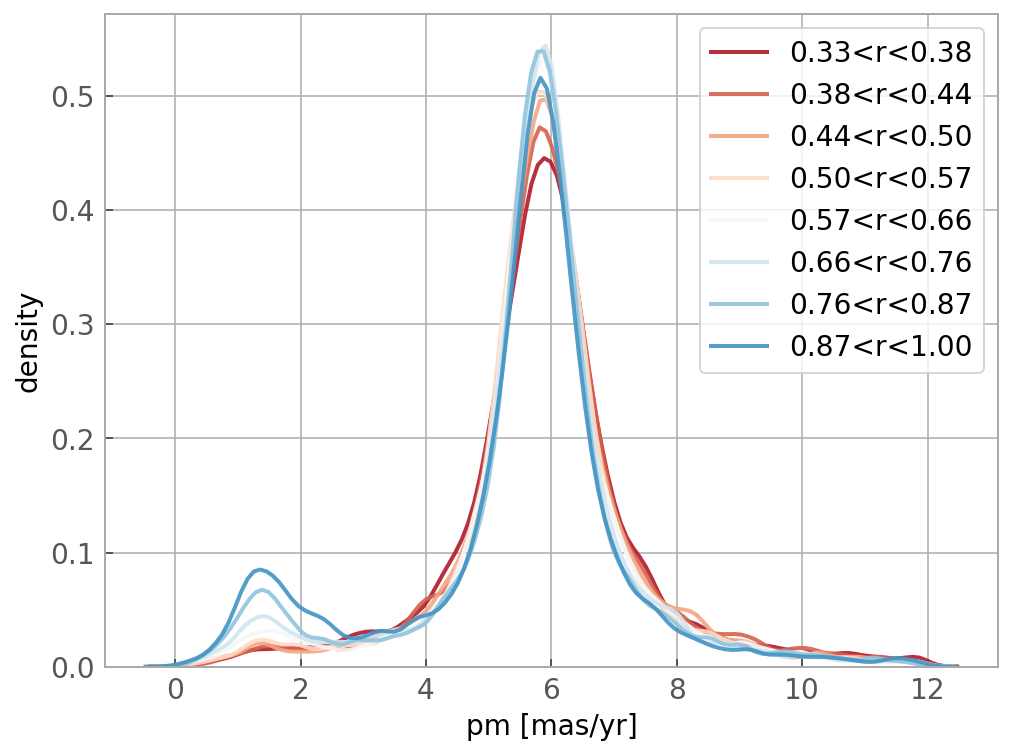

In [20]:
bins = np.logspace(np.log10(0.33), 0, 9)

r_rbin, z_rbin, z_bins = GC.bin_profile(bins, plot={'z_clip':[0, 12]});


PM radial profile

<Figure size 504x360 with 0 Axes>

Text(0.5,0,'r')

Text(0,0.5,'PM')

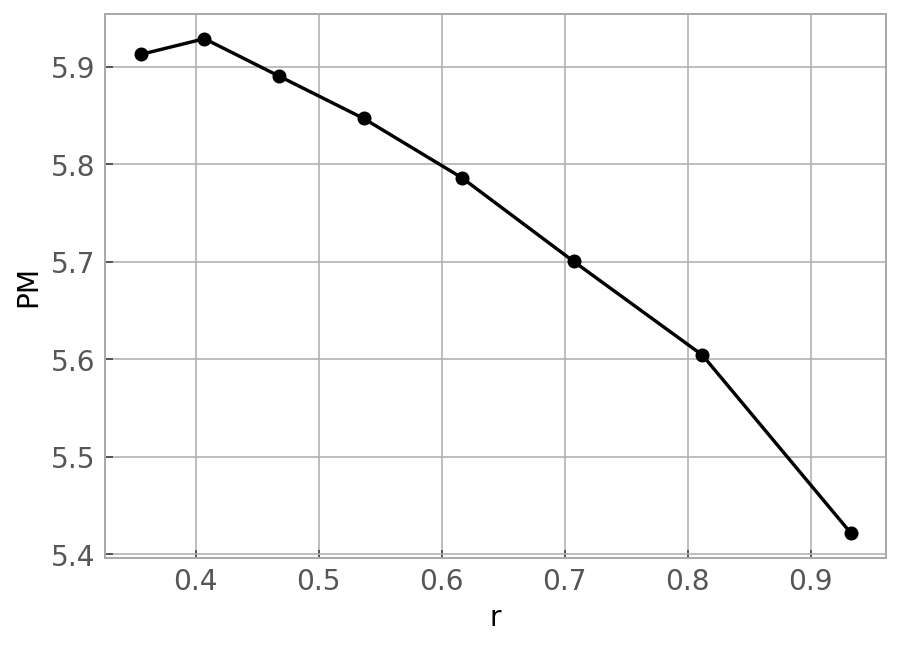

In [21]:
plt.figure(figsize=(7,5))
plt.plot(r_rbin, z_rbin, "k-o")
plt.xlabel("r")
plt.ylabel("PM")

### GMM start from here

Perform GMM decomposition. The best number of gaussians is given by the lowest BIC. One can also specify the number of components by giving values to parameter n_comp in GMM( ).

GMM_bins

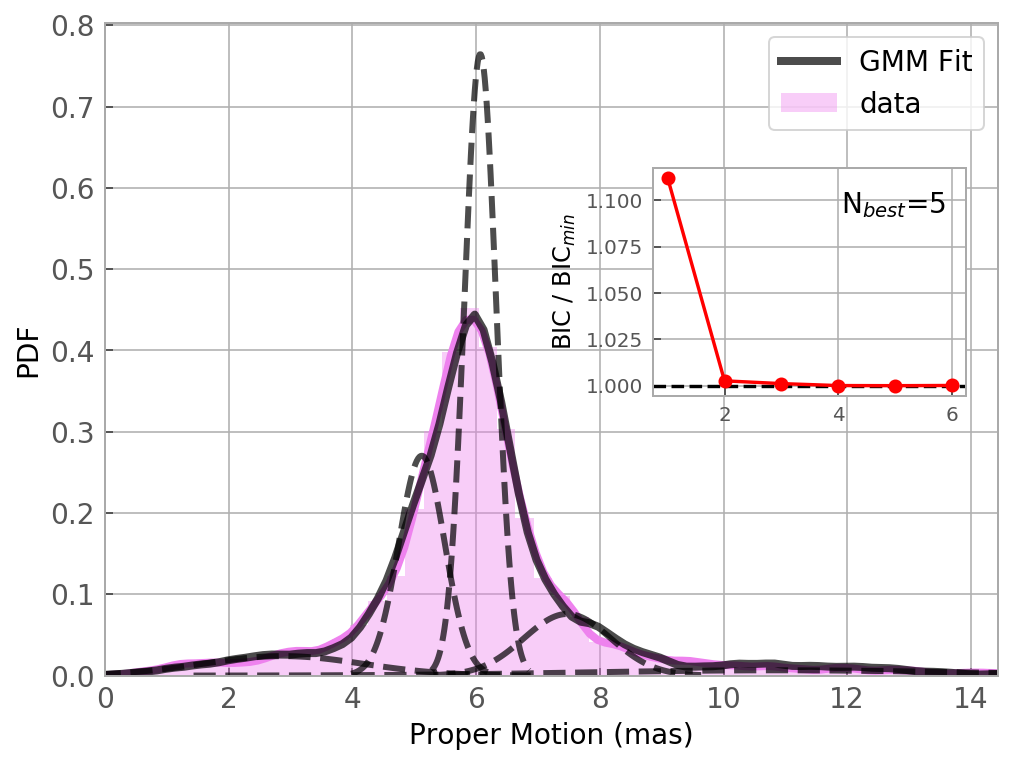

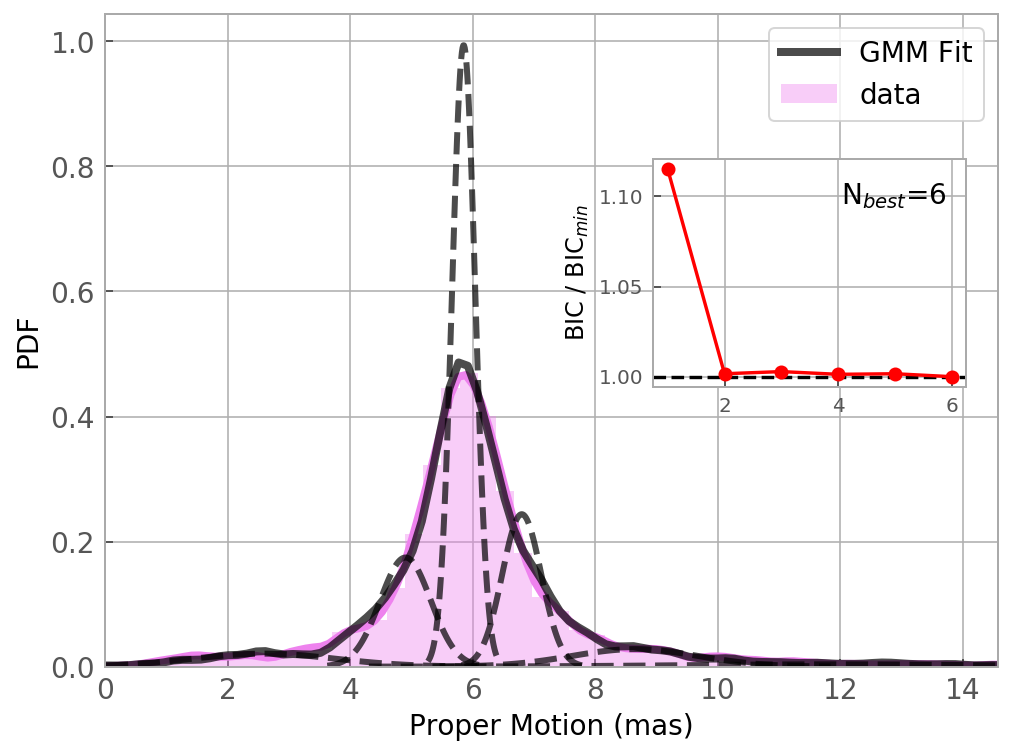

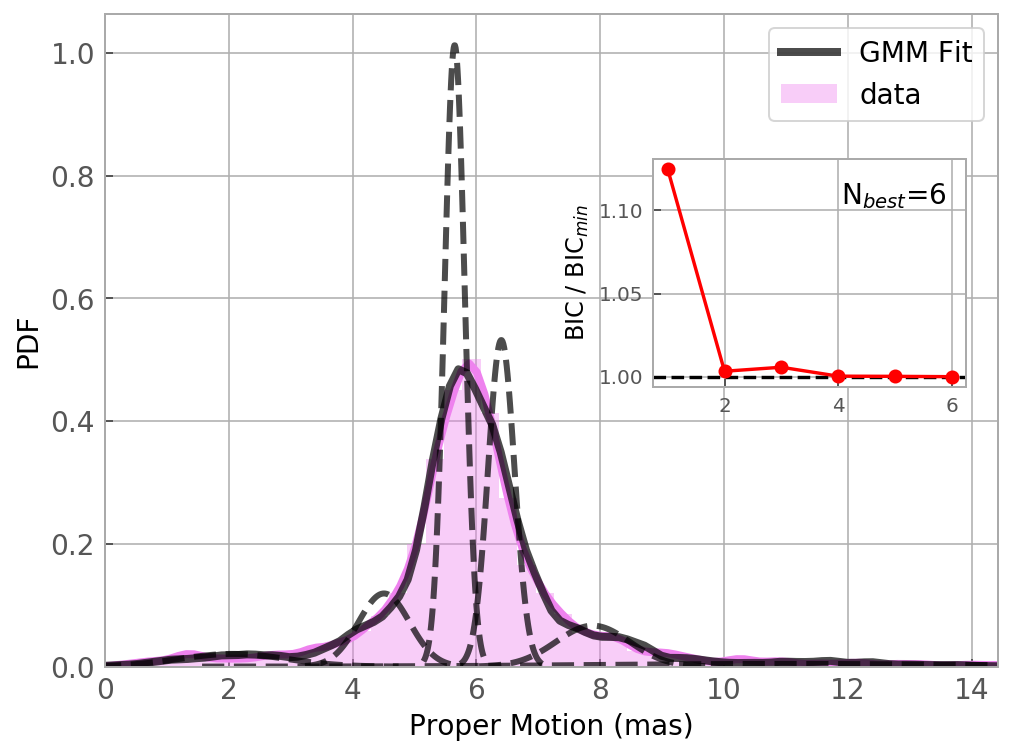

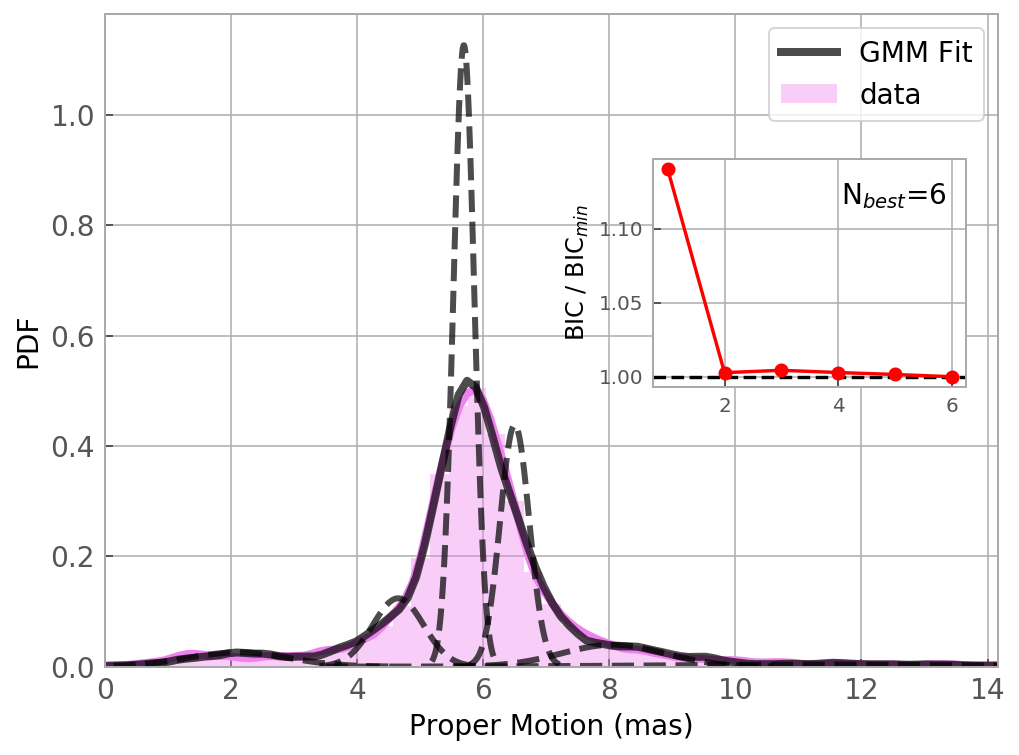

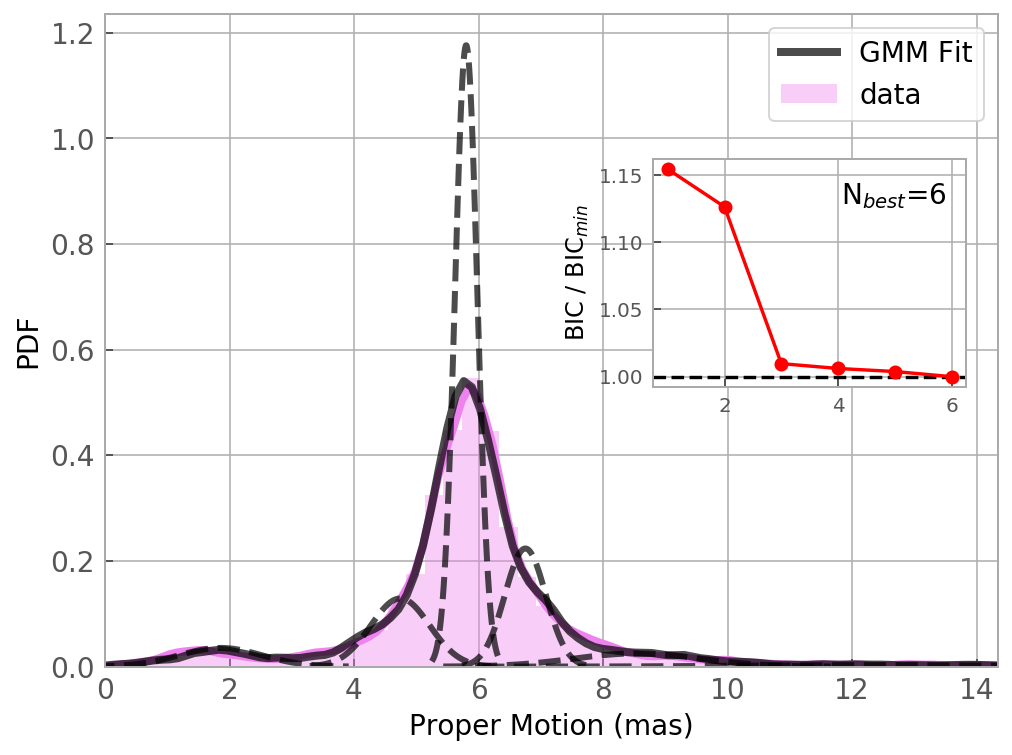

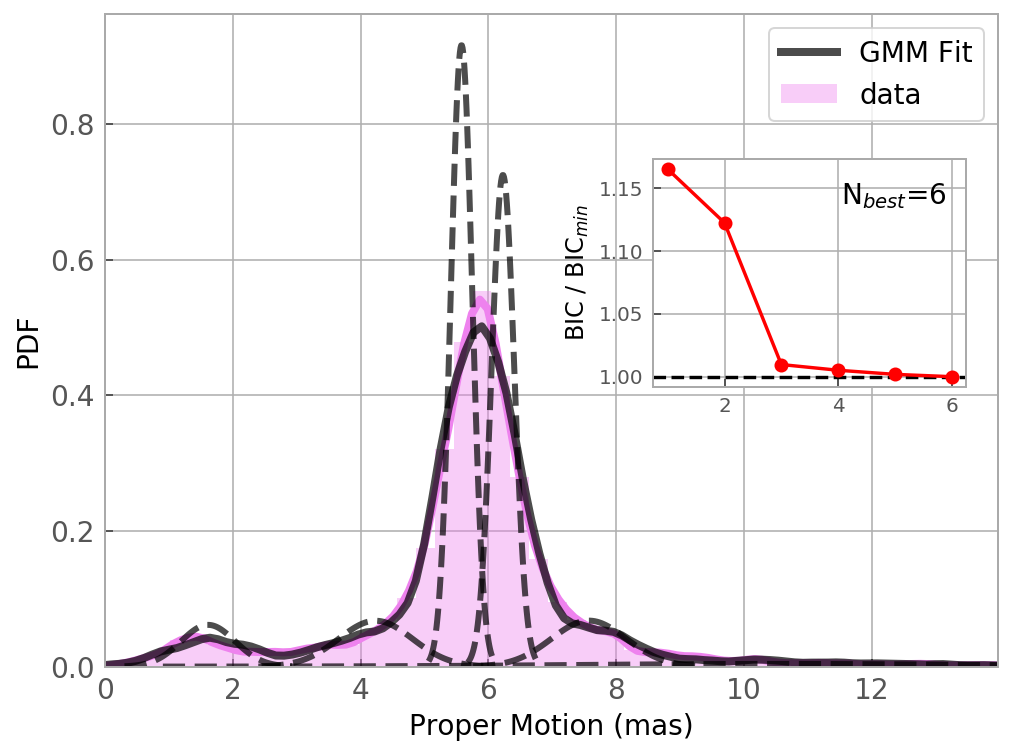

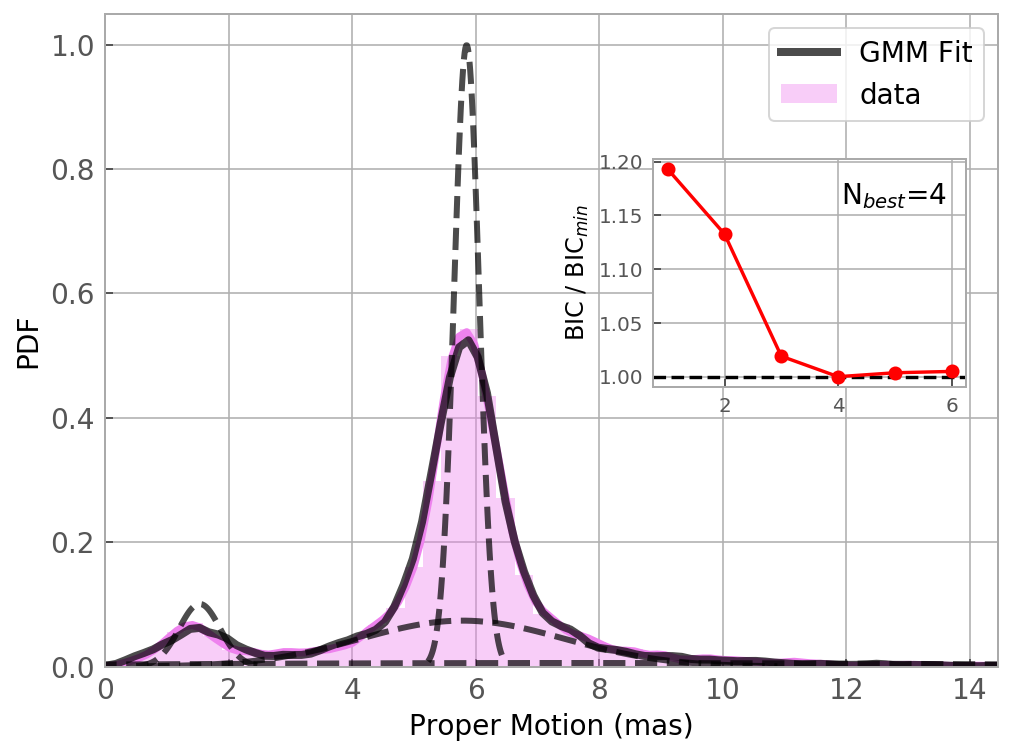

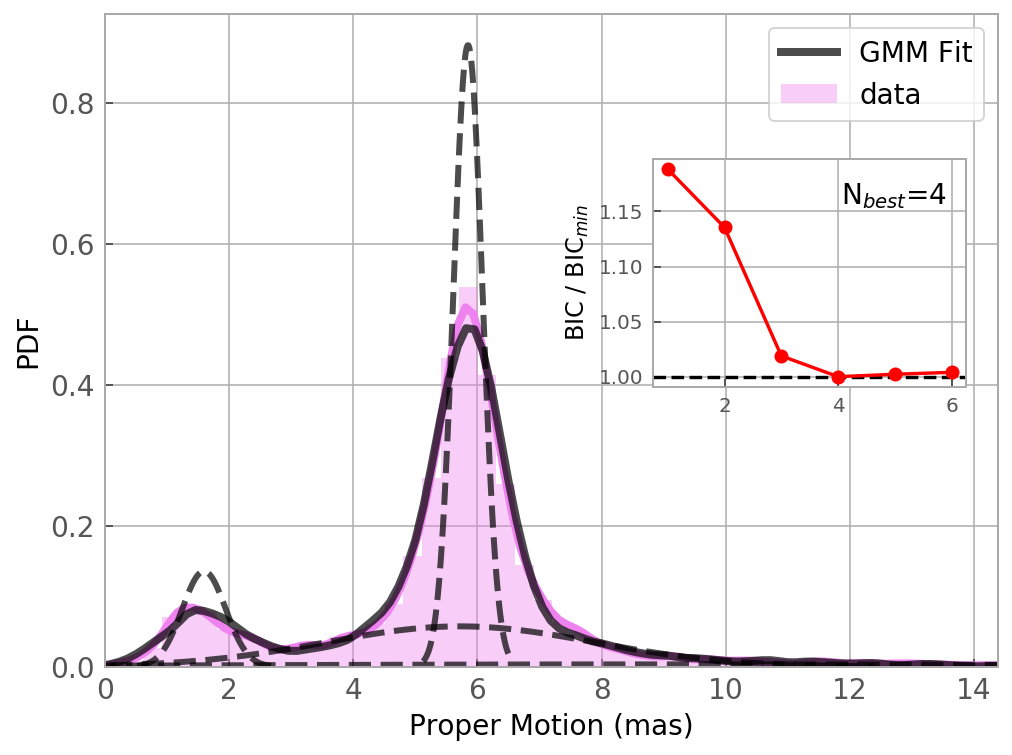

Finished


In [22]:
GC.makeGMM(bins)

GC.runGMM(max_n_comp=6, plot=True)

In [23]:
data = z_bins[5]["pm"]
prob_main_pop = GC.GMM.gmms[5].predict_main_pop(data)
prob_main_pop

array([0.99947623, 0.99969972, 0.99202094, ..., 0.99925004, 0.9996173 ,
       0.00456084])

In [24]:
GC.predictMainPop(z_bins[5]["pm"], 5)

array([0.99947623, 0.99969972, 0.99202094, ..., 0.99925004, 0.9996173 ,
       0.00456084])

[5.58361406 6.33987719 6.56852014 ... 5.68965421 5.62286924 6.39142296]


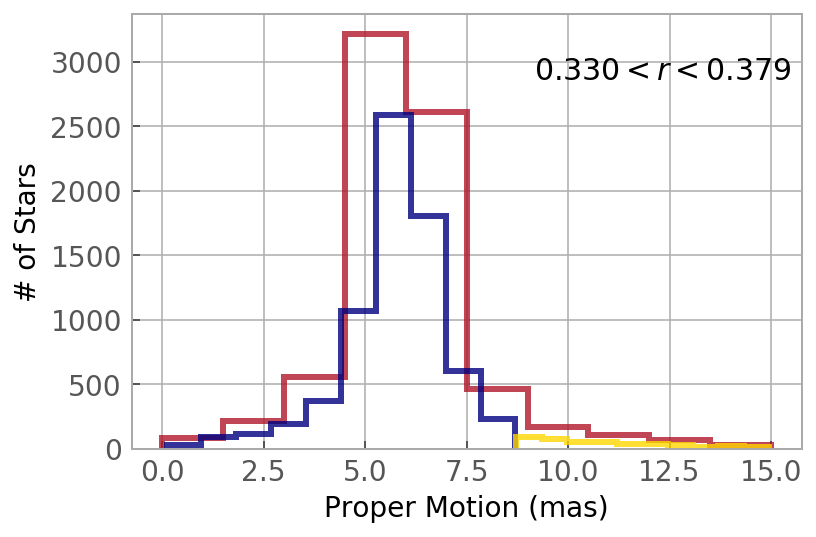

[5.43496268 5.86884437 5.63099179 ... 7.01268621 6.27794362 9.66565976]


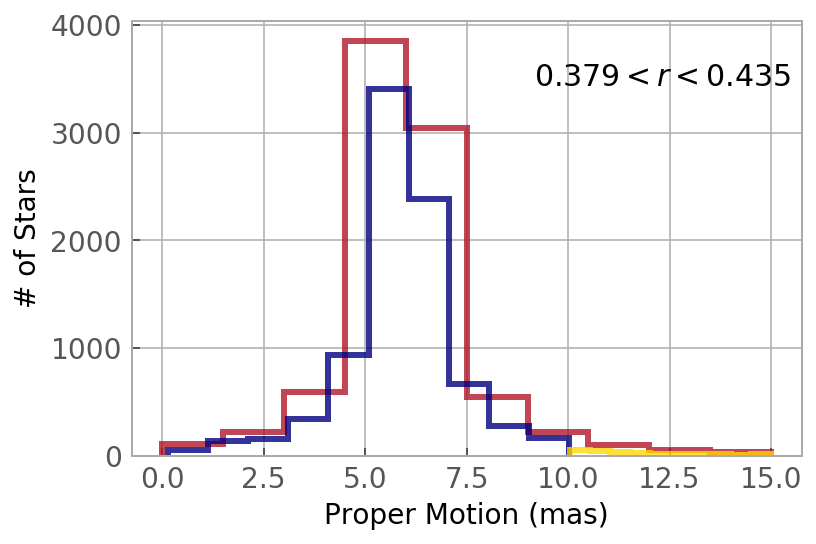

[9.1606526  6.48773385 5.86827537 ... 5.24817927 5.56985475 4.52348894]


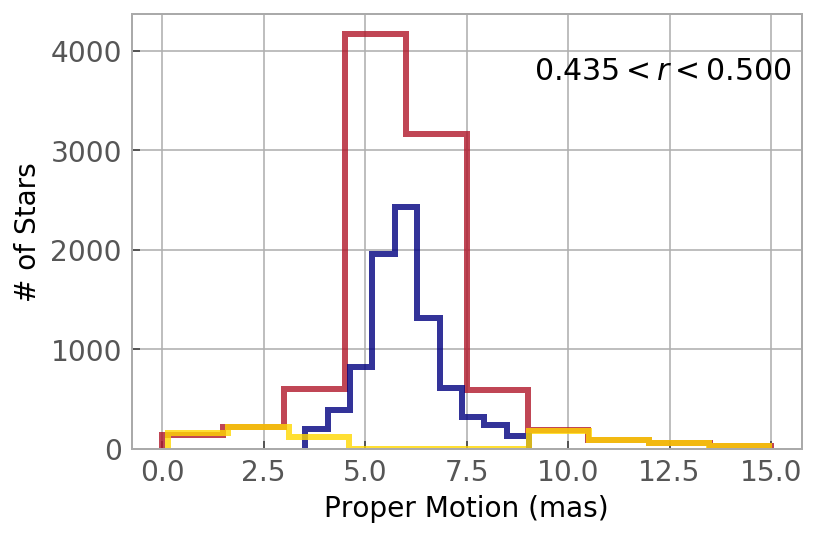

[7.76344038 6.85230547 6.68161281 ... 8.21350467 5.8913663  5.82531549]


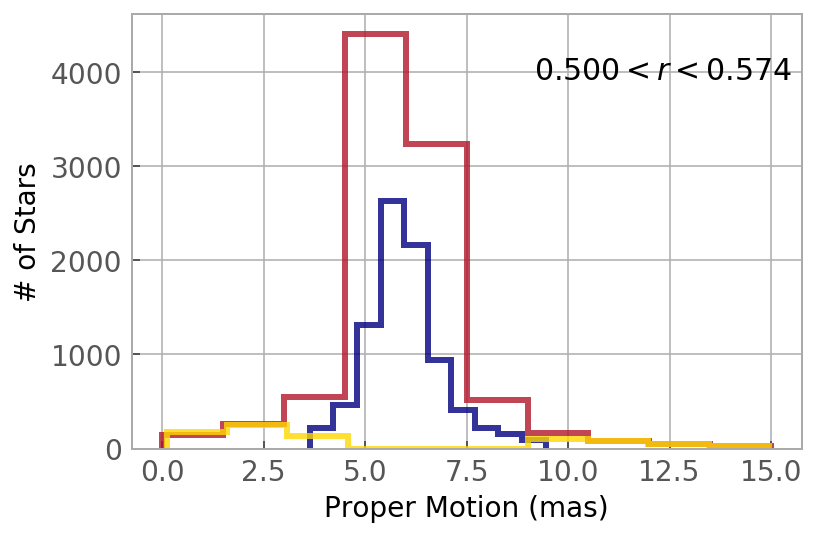

[5.84550748 6.01711907 7.18432122 ... 5.64677884 9.23277369 5.64885199]


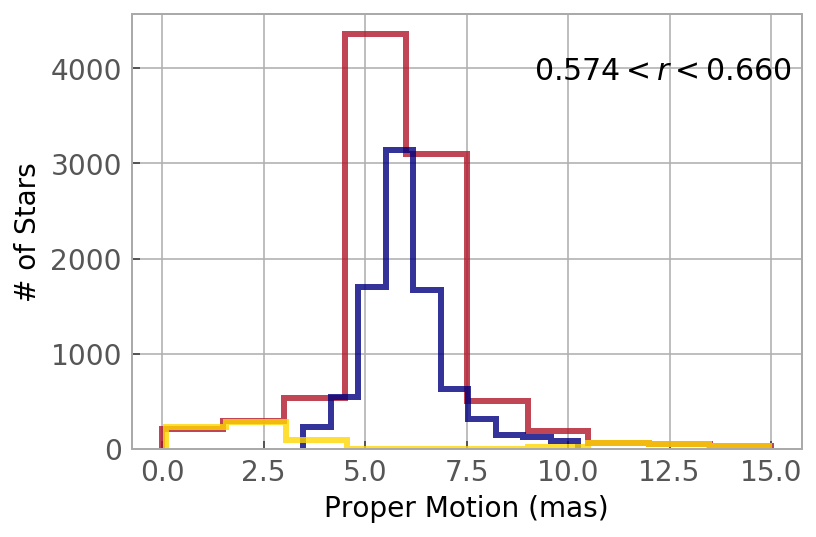

[6.00306609 5.63815403 3.6475262  ... 4.08646443 4.5911046  1.68296685]


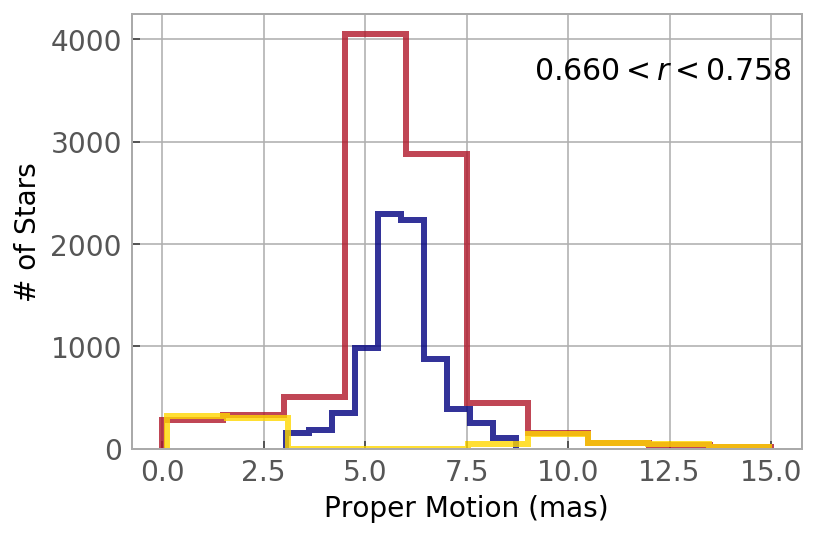

[ 6.25372089  5.56682242 12.39691999 ...  6.39202383  6.58556724
  6.84720064]


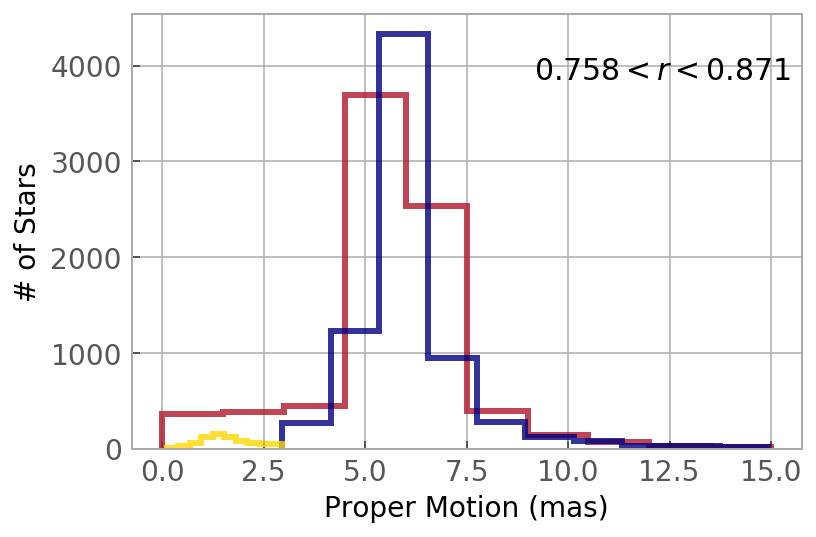

[1.75185959 6.32056927 1.76151492 ... 5.67177947 6.02753065 4.90085548]


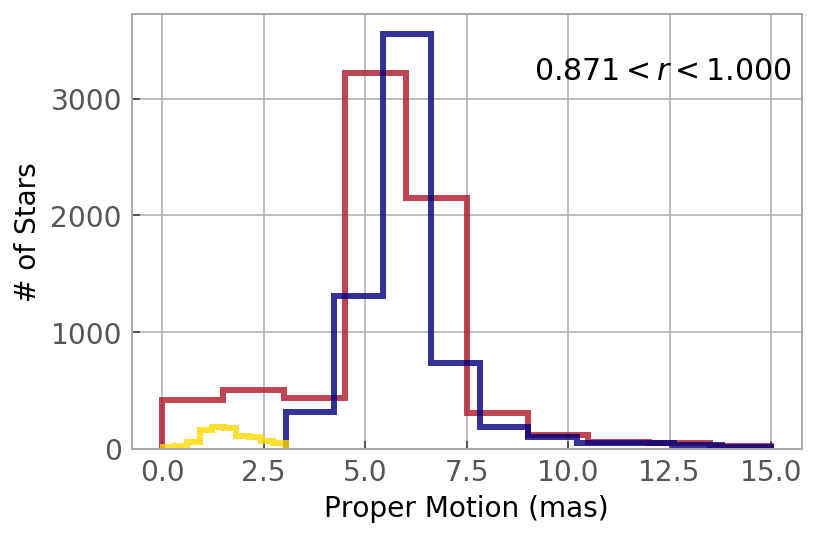

In [25]:
GC.GMM.plot_pred_main_pop(p_thre=0.8)

<br><br>

- - - 
- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>